# Testing correction algorithms on slope distortion

In [1]:
import json
import emip_toolkit as EMTK
from correction import *
import numpy as np
import drift_algorithms as algo
from tqdm import tqdm
import statistics
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload

### Read synthetic data:

In [2]:
file = open('synthetic_dataset_with_time.txt', 'r')
text = file.read()
data = json.loads(text)

### Process synthetic text with EMTK:

In [3]:
# find areas of interest (AOIs) once again
image_path = "./"
image = "synthetic_text.png"
aoi = EMTK.find_aoi(image, image_path, level="sub-line")

# add tokens to AOIs 
file_path = "./"
aois_with_tokens = EMTK.add_tokens_to_AOIs(file_path, image.split(".")[0]+".txt", aoi)
aois_with_tokens.head()

# find the y coordinate of each line in the text
line_ys = find_lines_Y(aoi)

### Draw raw fixations:

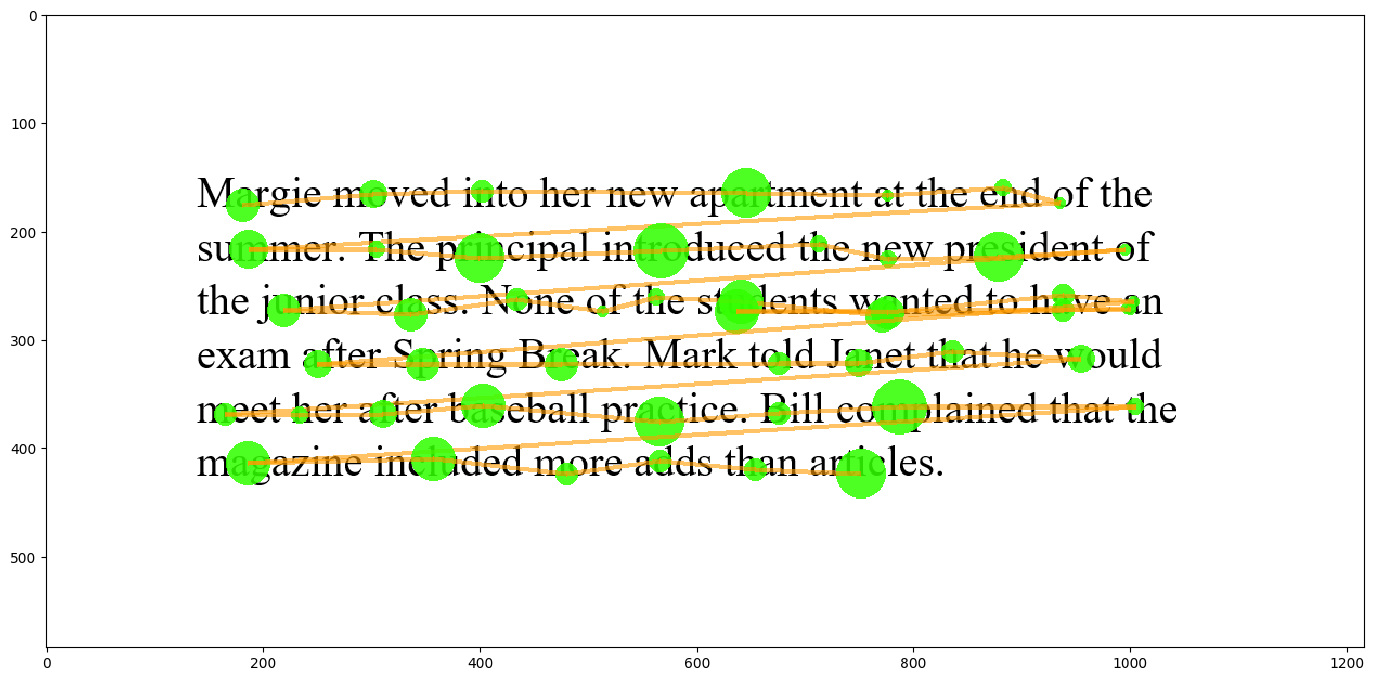

In [4]:
# draw original correct fixations
draw_fixation('synthetic_text.png', data['robot1'].copy())

### Draw fixations with extreme slope distortion (d_slope=0.1):

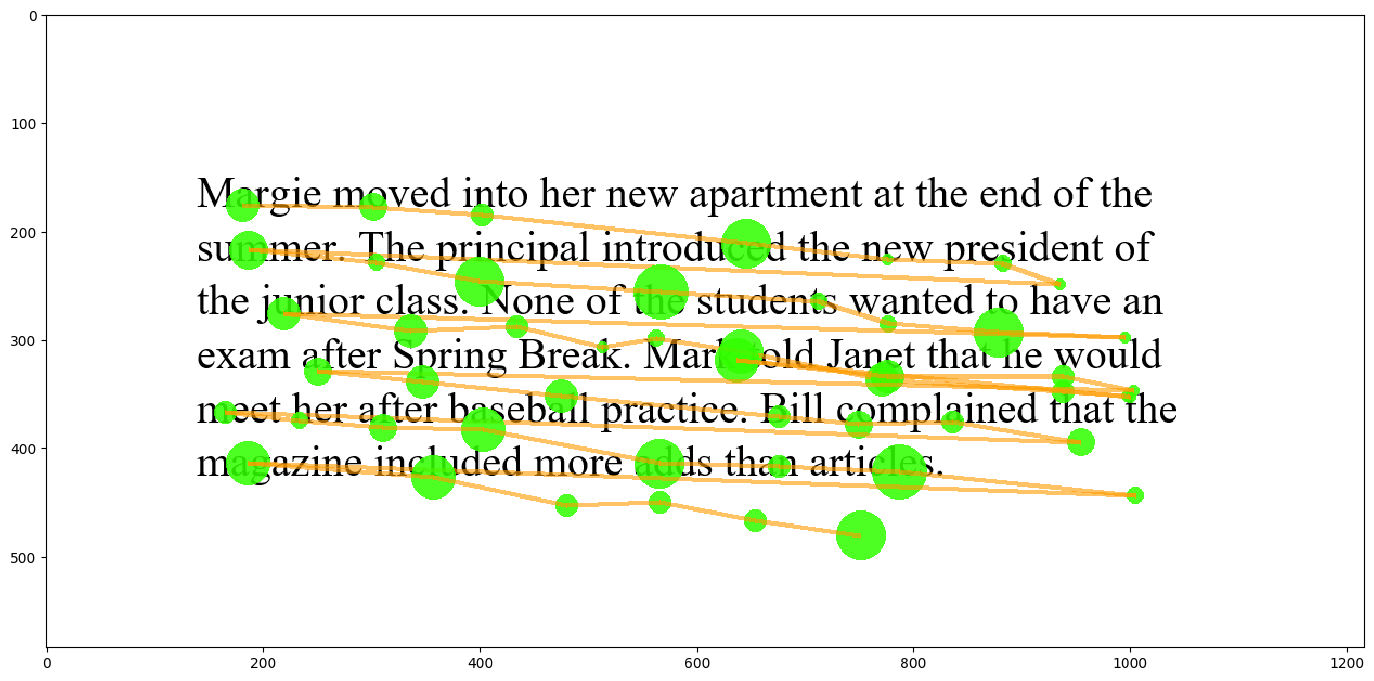

In [5]:
# generate slope distortion over the correct trial
slope_dist_test = slope_distortion(data['robot1'].copy(), 0.1)

# draw the trial with added error
draw_fixation('synthetic_text.png', slope_dist_test)

### Test correction algorithms on slope distortion:
Each of the 100 data points is tested at 10 levels of distortion [0, 0.1] with all 10 algorithms

In [6]:
attach_results = [[],[],[],[],[],[],[],[],[],[],[]]
chain_results = [[],[],[],[],[],[],[],[],[],[],[]]
cluster_results = [[],[],[],[],[],[],[],[],[],[],[]]
compare_results = [[],[],[],[],[],[],[],[],[],[],[]]
merge_results = [[],[],[],[],[],[],[],[],[],[],[]]
regress_results = [[],[],[],[],[],[],[],[],[],[],[]]
segment_results = [[],[],[],[],[],[],[],[],[],[],[]]
split_results = [[],[],[],[],[],[],[],[],[],[],[]]
stretch_results = [[],[],[],[],[],[],[],[],[],[],[]]
warp_results = [[],[],[],[],[],[],[],[],[],[],[]]

word_centers = find_word_centers(aoi)
word_centers = np.array(word_centers.copy(), dtype=int)

duration_word_centers = find_word_centers_and_duration(aois_with_tokens)
duration_word_centers = np.array(duration_word_centers.copy(), dtype=int)

# MAKE SURE YOU RUN THIS 100 TIMES, NOT JUST ONE!!!
for robot_index in tqdm(range(100)):
    
    for error_probability in range(0, 11):
        # generate error
        slope_test = slope_distortion(data['robot' + str(robot_index)].copy(),
                                      error_probability/100)

        # attach correction
        np_array = np.array(slope_test.copy())
        attach_correction = algo.attach(np_array, line_ys)
        percentage, match_list = correction_quality(aoi,
                                                    data['robot' + str(robot_index)].copy(),
                                                    attach_correction)
        attach_results[error_probability].append(percentage)

        # chain correction
        np_array = np.array(slope_test.copy())
        chain_correction = algo.chain(np_array, line_ys)
        percentage, match_list = correction_quality(aoi,
                                                    data['robot' + str(robot_index)].copy(),
                                                    chain_correction)
        chain_results[error_probability].append(percentage)

        # cluster correction
        np_array = np.array(slope_test.copy())
        cluster_correction = algo.cluster(np_array, line_ys)
        percentage, match_list = correction_quality(aoi,
                                                    data['robot' + str(robot_index)].copy(),
                                                    cluster_correction)
        cluster_results[error_probability].append(percentage)
        
        # compare correction
        np_array = np.array(slope_test.copy())
        compare_correction = algo.compare(np_array, word_centers)
        percentage, match_list = correction_quality(aoi,
                                                    data['robot' + str(robot_index)].copy(),
                                                    compare_correction)
        compare_results[error_probability].append(percentage)

        # merge correction
        np_array = np.array(slope_test.copy())
        merge_correction = algo.merge(np_array, line_ys)
        percentage, match_list = correction_quality(aoi,
                                                    data['robot' + str(robot_index)].copy(),
                                                    merge_correction)
        merge_results[error_probability].append(percentage)

        # regress correction
        np_array = np.array(slope_test.copy())
        regress_correction = algo.regress(np_array, line_ys)
        percentage, match_list = correction_quality(aoi,
                                                    data['robot' + str(robot_index)].copy(),
                                                    regress_correction)
        regress_results[error_probability].append(percentage)

        # segment correction
        np_array = np.array(slope_test.copy())
        segment_correction = algo.segment(np_array, line_ys)
        percentage, match_list = correction_quality(aoi,
                                                    data['robot' + str(robot_index)].copy(),
                                                    segment_correction)
        segment_results[error_probability].append(percentage)

        # split correction
        np_array = np.array(slope_test.copy())
        split_correction = algo.split(np_array, line_ys)
        percentage, match_list = correction_quality(aoi,
                                                    data['robot' + str(robot_index)].copy(),
                                                    split_correction)
        split_results[error_probability].append(percentage)

        # stretch correction
        np_array = np.array(slope_test.copy())
        stretch_correction = algo.stretch(np_array, line_ys)
        percentage, match_list = correction_quality(aoi,
                                                    data['robot' + str(robot_index)].copy(),
                                                    stretch_correction)
        stretch_results[error_probability].append(percentage)
        
        # warp correction
        np_array = np.array(slope_test.copy(), dtype=int)
        durations = np.delete(np_array, 0, 1)
        durations = np.delete(durations, 0, 1)
        np_array = np.delete(np_array, 2, 1)
        
        warp_correction = algo.warp(np_array, word_centers)
        percentage, match_list = correction_quality(aoi,
                                                    data['robot' + str(robot_index)].copy(),
                                                    warp_correction)
        warp_results[error_probability].append(percentage)

        '''
        if percentage < 1:
            draw_correction('synthetic_text.png', warp_correction, match_list)
            print("robot:", robot_index, "    error probability:", error_probability)
        '''

100%|██████████| 100/100 [22:00<00:00, 13.20s/it]


### Function to calculate mean error:

In [7]:
def mean_error_group(results):
    new_list = []
    
    for result in results:
        new_list.append(statistics.mean(result))
        
    return new_list

### Compute mean error (accuracy) for each algorithm:

In [8]:
mean_attach_results = mean_error_group(attach_results)
mean_chain_results = mean_error_group(chain_results)
mean_cluster_results = mean_error_group(cluster_results)
mean_compare_results = mean_error_group(compare_results)
mean_merge_results = mean_error_group(merge_results)
mean_regress_results = mean_error_group(regress_results)
mean_segment_results = mean_error_group(segment_results)
mean_split_results = mean_error_group(split_results)
mean_stretch_results = mean_error_group(stretch_results)
mean_warp_results = mean_error_group(warp_results)

### Plot accuracy vs distortion for each algorithm:

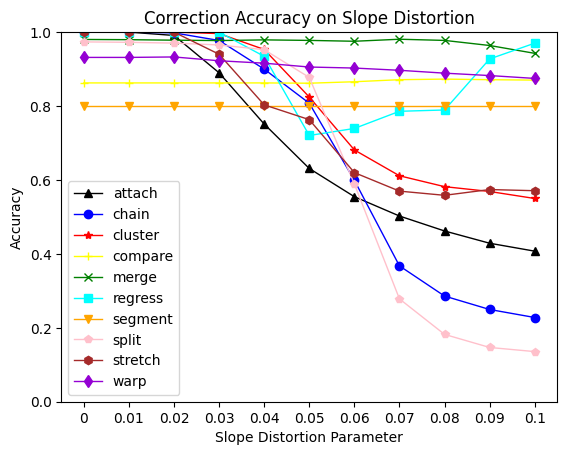

In [13]:
plt.plot(mean_attach_results, color='Black', linewidth=1, marker='^')
plt.plot(mean_chain_results, color='Blue', linewidth=1, marker='o')
plt.plot(mean_cluster_results, color='Red', linewidth=1, marker='*')
plt.plot(mean_compare_results, color='Yellow', linewidth=1, marker='+')
plt.plot(mean_merge_results, color='Green', linewidth=1, marker='x')
plt.plot(mean_regress_results, color='Aqua', linewidth=1, marker='s')
plt.plot(mean_segment_results, color='Orange', linewidth=1, marker='v')
plt.plot(mean_split_results, color='Pink', linewidth=1, marker='p')
plt.plot(mean_stretch_results, color='Brown', linewidth=1, marker='h')
plt.plot(mean_warp_results, color='DarkViolet', linewidth=1, marker='d')

plt.title('Correction Accuracy on Slope Distortion')
plt.legend(['attach', 'chain', 'cluster', 'compare', 'merge', 'regress', 'segment', 'split', 'stretch', 'warp'])
plt.ylabel('Accuracy')
plt.xlabel('Slope Distortion Parameter')
plt.ylim(0, 1)

x_ticks_labels = ['0', '0.01', '0.02', '0.03', '0.04', '0.05', '0.06', '0.07', '0.08', '0.09', '0.1']
plt.xticks(range(0, 11), x_ticks_labels)
plt.savefig("slope_dist_accuracy.png")
plt.show()

### Average over distortion:

In [10]:
print("mean attach:", statistics.mean(mean_attach_results))
print("mean chain:", statistics.mean(mean_chain_results))
print("mean cluster:", statistics.mean(mean_cluster_results))
print("mean compare:", statistics.mean(mean_compare_results))
print("mean merge:", statistics.mean(mean_merge_results))
print("mean regress:", statistics.mean(mean_regress_results))
print("mean segment:", statistics.mean(mean_segment_results))
print("mean split:", statistics.mean(mean_split_results))
print("mean stretch:", statistics.mean(mean_stretch_results))
print("mean warp:", statistics.mean(mean_warp_results))

mean attach: 0.6926028984615784
mean chain: 0.6738843359036049
mean cluster: 0.79696748473401
mean compare: 0.8659919100449813
mean merge: 0.9737930552063042
mean regress: 0.8969854897835305
mean segment: 0.798784756916433
mean split: 0.6402924429571778
mean stretch: 0.7636036180096932
mean warp: 0.9077896600873512
